# Superdense Coding using Rydberg Atoms
          (Neutral Atom Quantum Computing Simulation)


> Devesh Kumar          
> MSc Physics-II

## Superdense Coding Protocol
    Transmitting two classical bits using one qubit.
Superdense coding is a procedure of sending two classical bits to someone using just a single qubit of communication. It is different from Quantum teleportation protocol. Quantum teleportation is a process by which the state of qubit (|ψ⟩) can be transmitted from one location to another, using two bits of classical communication and a Bell pair.

#### The process:
<img src = 'sdc.png' width = '800' height = '600' align = 'center'></img>


### Step 1:
The process starts with creating a Bell state. A third party preapares two qubit in an entangled state. He applies Hadamard gate (H) to the first qubit to create superposition. He then applies CNOT gate (C-NOT) using the first qubit as a control and the second as the target. This is the entangled state (Bell pair).

For our simulation, we label qubits (neutral atoms) as `q0` and `q1`.

### Step 2:
Now the third party sends the first qubit `q0` to Alice and the second qubit `q1` to Bob. This protocol aims to send 2 classical bits of information form Alice to Bob using her qubit. Depending on the 2 bits of information she wants to send, she needs to apply a set of quantum gates to her qubit.

<table>
  <tr>
    <th>Message</th>
    <th>Applied Gates</th>
  </tr>
  <tr>
    <td>00</td>
    <td>I</td>
  </tr>
  <tr>
    <td>01</td>
    <td>X</td>
  </tr>
  <tr>
    <td>10</td>
    <td>Z</td>
  </tr>
  <tr>
    <td>11</td>
    <td>XZ</td>
  </tr>
</table>

Depending on what message she wants to send, she applies the appropriate gate and then sends her qubit to Bob for the final step in the process.

### Step 3:
Bob receives Alice's qubit and uses his qubit to decode Alice's message. Notice that in this process, he does not need to have knowledge of the state in order to decode it.
Bob applies a CNOT gate using the Alice's qubit as control and other as target. Then he applies a Hadamard gate and finally performs a measurement on both qubits to extract Alice's message.



###### Ref: https://qiskit.org/textbook/ch-algorithms/superdense-coding.html

## Simulating the Superdense Coding Protocol
For simulating Superdense coding on neutral atom device, we start with importing some packages including Pulser.

In [1]:
#Some imports from Pulser
import pulser
from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2
from pulser.waveforms import BlackmanWaveform, ConstantWaveform
from pulser.simulation import Simulation

#Some general imports
import numpy as np
import matplotlib.pyplot as plt
import qutip
from itertools import product

from IPython.display import display, Markdown, clear_output
import ipywidgets as wid

### Defining Register
Now we define two qubits (neutral atoms) by providing their coordinates using `pulser.Register`.

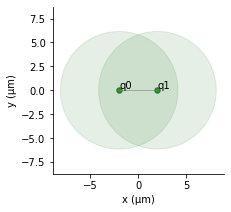

In [45]:
qubits = {'q0': (-2,0) , 'q1': (2,0) }

Omega_max = 0.5 * np.pi
blockade_radius = Chadoq2.rydberg_blockade_radius(Omega_max)

reg = Register(qubits)
reg.draw(blockade_radius=blockade_radius, 
         draw_half_radius=True, draw_graph = True)

### Pulse Sequence
In this section we define the pulse sequence for the implimentation of the protocol.

In [5]:
#Defining the pulses

half_pi_wf = BlackmanWaveform(300, np.pi/2)
half_pi_pulse = Pulse.ConstantDetuning(half_pi_wf, 0, -np.pi/2)
half_pi_pulse_d = Pulse.ConstantDetuning(half_pi_wf, 0, np.pi/2)

pi_wf = BlackmanWaveform(300, np.pi)
pi_pulse = Pulse.ConstantDetuning(pi_wf, 0, 0)

twopi_wf = BlackmanWaveform(300, 2*np.pi)
twopi_pulse = Pulse.ConstantDetuning(twopi_wf, 0, 0)

#### Creating Entangled Pair
To prepare the qubits in a Bell pair, we apply the $\pi/2$ pulse (H-gate) on `q0`. Then the C-NOT sequence with `q0` as control and `q1` as target, using `pulser.Sequence`.

In [46]:
seq = Sequence(reg, Chadoq2)

#Declare channel
seq.declare_channel('raman', 'raman_local', 'q0')
seq.declare_channel('ryd', 'rydberg_local', 'q0')

#Hadamard sequence
seq.add(half_pi_pulse, 'raman')

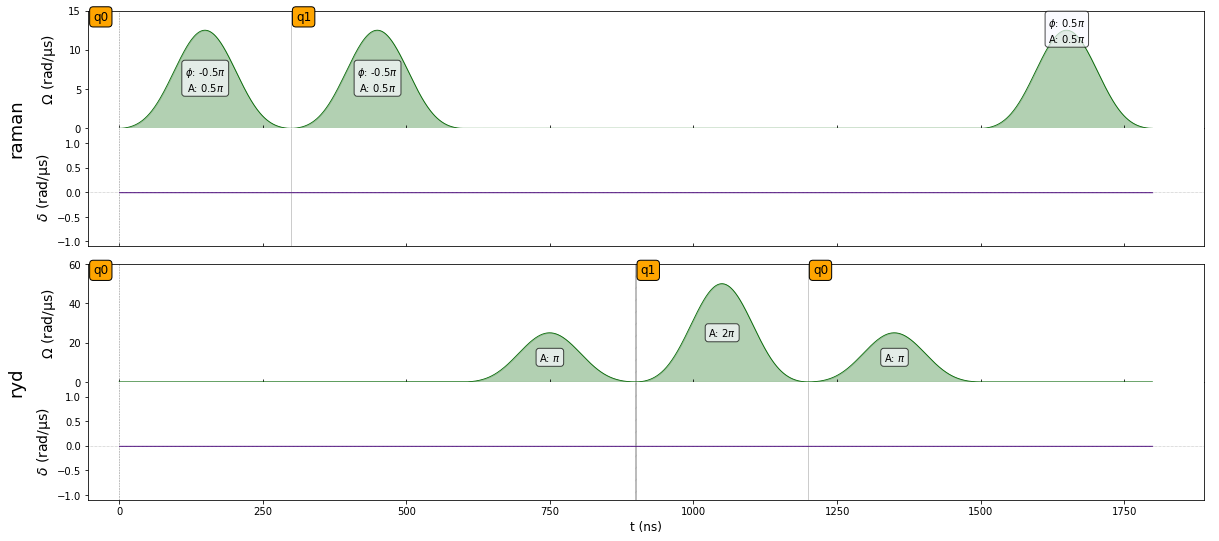

In [48]:
#CNOT sequence:
seq.target('q1', 'raman')
seq.add(half_pi_pulse, 'raman')
seq.align('raman', 'ryd')

seq.add(pi_pulse, 'ryd')
seq.target('q1', 'ryd')    # Changes to target qubit
seq.add(twopi_pulse, 'ryd')
seq.target('q0', 'ryd')     # Changes back to control qubit
seq.add(pi_pulse, 'ryd')

seq.align('raman', 'ryd')
#seq.target('q0', 'raman')
seq.add(half_pi_pulse_d, 'raman')


seq.draw(draw_phase_area = True)

Let's see if the Bell State is prepared:


 Conts: Counter({'11': 5008, '00': 4989, '01': 3})



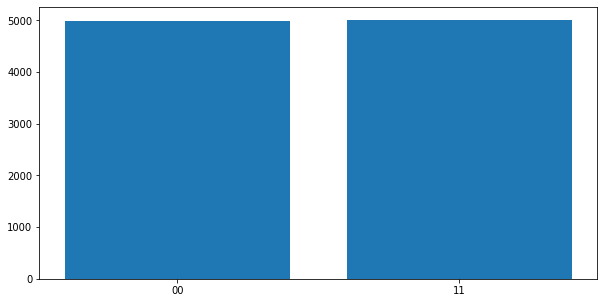

In [49]:
# Construct Simulation instance

sim = Simulation(seq)
res = sim.run()

count = res.sample_final_state(N_samples=1e4)
print(f'\n Conts: {count}\n')
 
most_freq = {k:v for k,v in count.items() if v>5}

plt.figure(figsize=(10,5))
plt.bar(list(most_freq.keys()), list(most_freq.values()), width = 0.8)
plt.xticks()

plt.show()

#### Encoding the message
Now for the case of our simulation, we've to assume that these entangled qubits are shared with Alice and Bob. We proceed with the encoding part of Alice. For the encoding part, we check the message and apply the pulses for X and Z gate accordingly, using conditional statement.

In [50]:
#Intended Message

msg = '01'

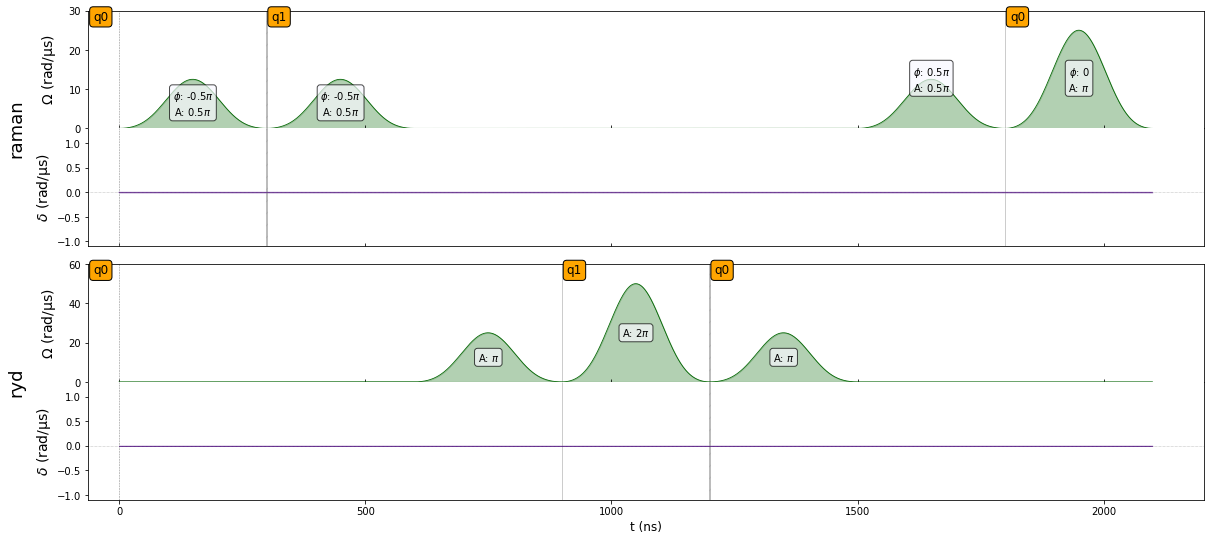

In [51]:
seq.target('q0', 'raman')

if len(msg) != 2 or not set([0,1]).issubset({0,1}):
    raise ValueError(f"message '{msg}' is invalid")

if msg[1] == "1":
    seq.add(pi_pulse, 'raman')

if msg[0] == "1":
    seq.phase_shift(np.pi, 'q0', basis='digital')

seq.draw(draw_phase_area = True, draw_phase_shifts = True)

#### Decoding the message
We assume, Bob receives Alice's qubit. Now we'll apply C-NOT sequence using the Alice's qubit `q0` as control and other as target. Then a $\pi/2$ pulse (H-gate) and finally perform a measurement on both qubits to extract Alice's message.

In [52]:
#CNOT sequence:
seq.target('q1', 'raman')
seq.add(half_pi_pulse, 'raman')
seq.align('raman', 'ryd')

seq.add(pi_pulse, 'ryd')
seq.target('q1', 'ryd')    # Changes to target qubit
seq.add(twopi_pulse, 'ryd')
seq.target('q0', 'ryd')     # Changes back to control qubit
seq.add(pi_pulse, 'ryd')

seq.align('raman', 'ryd')
#seq.target('q0', 'raman')
seq.add(half_pi_pulse_d, 'raman')

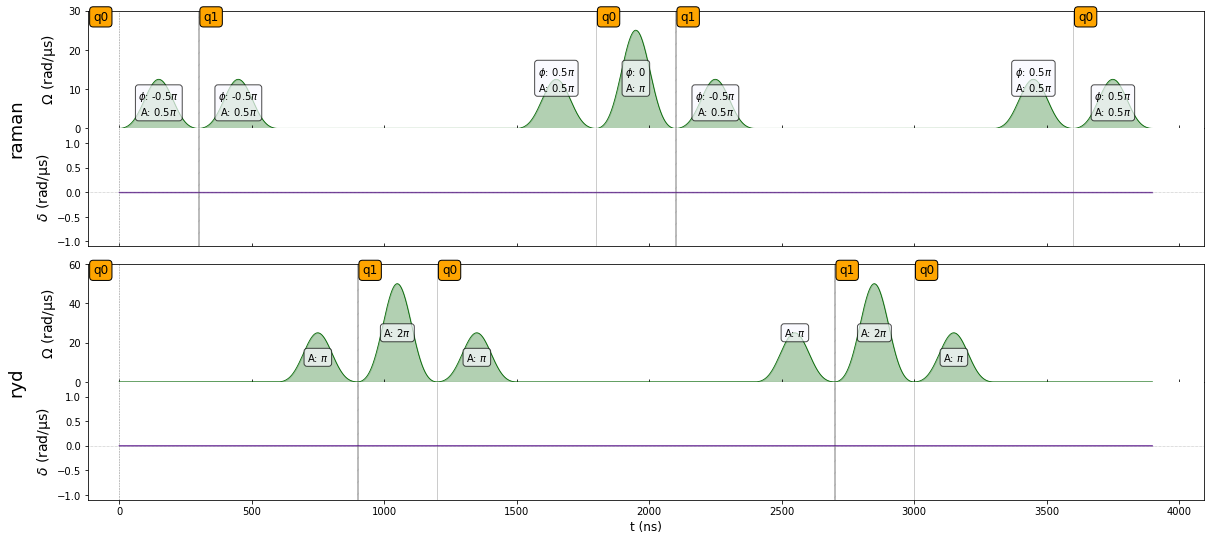

In [53]:
#Hadamard sequence
seq.target('q0', 'raman')
seq.add(half_pi_pulse_d, 'raman')

seq.draw(draw_phase_area = True)

Measuring the final state, to find the Alice's message.



Final states: Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[ 3.56136898e-05-2.15431229e-02j]
 [ 9.99767919e-01+0.00000000e+00j]
 [-4.02604723e-05-1.50929195e-07j]
 [ 7.03167752e-06+4.21713387e-09j]]

 Conts: Counter({'01': 9998, '00': 2})



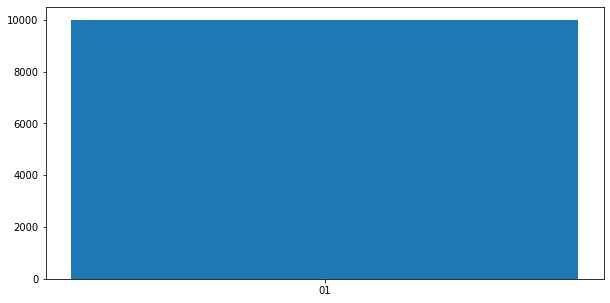

In [54]:
# Construct Simulation instance

sim = Simulation(seq)
res = sim.run()
    
final_st = res.get_final_state(reduce_to_basis='digital', tol = 1e-6)
print(f'\n\nFinal states: {final_st}')
    
count = res.sample_final_state(N_samples=1e4)
print(f'\n Conts: {count}\n')
 
most_freq = {k:v for k,v in count.items() if v>5}

plt.figure(figsize=(10,5))
plt.bar(list(most_freq.keys()), list(most_freq.values()), width = 0.8)
plt.xticks()
plt.show()